In [1]:
import xarray as xr
import numpy as np

import matplotlib.pyplot as plt 
import seaborn as sns

from RainySeason import *
from utils import *

mpl_settings() # general mpl settings
paper_plot() # more specific mpl settings

# Fig05: Metric sensitivity analysis

In [14]:
### load outputs
ds = xr.open_dataset('./outputs/Fig4_data.nc')

In [15]:
### Get normalized slopes for heatmap
Sindices = list(ds.data_vars)[0:10]
Sindices.pop(1); # remove R1day, as its not a very useful index for this
Sindices[1],Sindices[3] = Sindices[3],Sindices[1] # put DD and WD next to each other

Smetrics = list(ds.data_vars)[10:18] # RSO metrics
Emetrics = list(ds.data_vars)[18:] # RSE metrics

# prepare arrays for regression slope and r2 values
S_slope_array = np.zeros((len(Smetrics), len(Sindices)))
S_r2_array = np.zeros((len(Smetrics), len(Sindices)))
E_slope_array = np.zeros((len(Emetrics), len(Sindices)))
E_r2_array = np.zeros((len(Emetrics), len(Sindices)))

In [16]:
### calculate bin-weighted regression
n_bins = []
for j,climidx in enumerate(Sindices):
    #print(f'doing {climidx}')
    bin_edges, bin_centers = get_bin_widths(ds[climidx]) # get bin sizes
    x = ds.groupby_bins(group=climidx,bins=bin_edges).mean() # average by bins
    s = ds.groupby_bins(group=climidx,bins=bin_edges).count() # count per bin
    n_bins.append(len(bin_centers))
    
    for i,metric in enumerate(Smetrics):
        y = x[metric]
        weights=s[metric]
        # bin weighted linreg
        slope, r2, pvalue, y_hat = weighted_linregress(bin_centers, y, weights)

        if pvalue < 0.01:
            S_slope_array[i,j] = slope
            S_r2_array[i,j] = r2
        else:
            S_slope_array[i,j] = np.nan
            S_r2_array[i,j] = np.nan
            
    for k,metric in enumerate(Emetrics):
        y = x[metric]
        weights=s[metric]
        # bin weighted linreg
        slope, r2, pvalue, y_hat = weighted_linregress(bin_centers, y, weights)

        if pvalue < 0.01:
            E_slope_array[k,j] = slope
            E_r2_array[k,j] = r2
        else:
            E_slope_array[k,j] = np.nan
            E_r2_array[k,j] = np.nan

In [17]:
### a bit of string manipulation for the plot

# ETCCDI Indices 
plot_Sindices = Sindices.copy()
plot_Sindices[4] = 'pr_TOTAL'
plot_Sindices[4:] = ['$' + s.split('_')[0] + '_{' + s.split('_')[1] + '}$' for s in plot_Sindices[4:]]
units = ['[days]','[days]','[mm/day]']+list(np.repeat('[mm]',6))
plot_Sindices = [s + f' {units[i]}' for i,s in enumerate(plot_Sindices)]

# RSO metrics
plot_Smetrics = Smetrics.copy()
plot_Smetrics = ['$RSO_{' + s.split('_')[1] + '}$' for s in plot_Smetrics]
plot_Smetrics[-2] = '$RSO_{LM}$'
plot_Smetrics[-1] = '$RSO_{CB}$'

# RSE metrics
plot_Emetrics = Emetrics.copy()
plot_Emetrics = ['$RSE_{' + s.split('_')[1] + '}$' for s in plot_Emetrics]
plot_Emetrics[-2] = '$RSE_{LM}$'
plot_Emetrics[-1] = '$RSE_{CB}$'
plot_Emetrics.insert(3,'')
plot_Emetrics.insert(3,'')

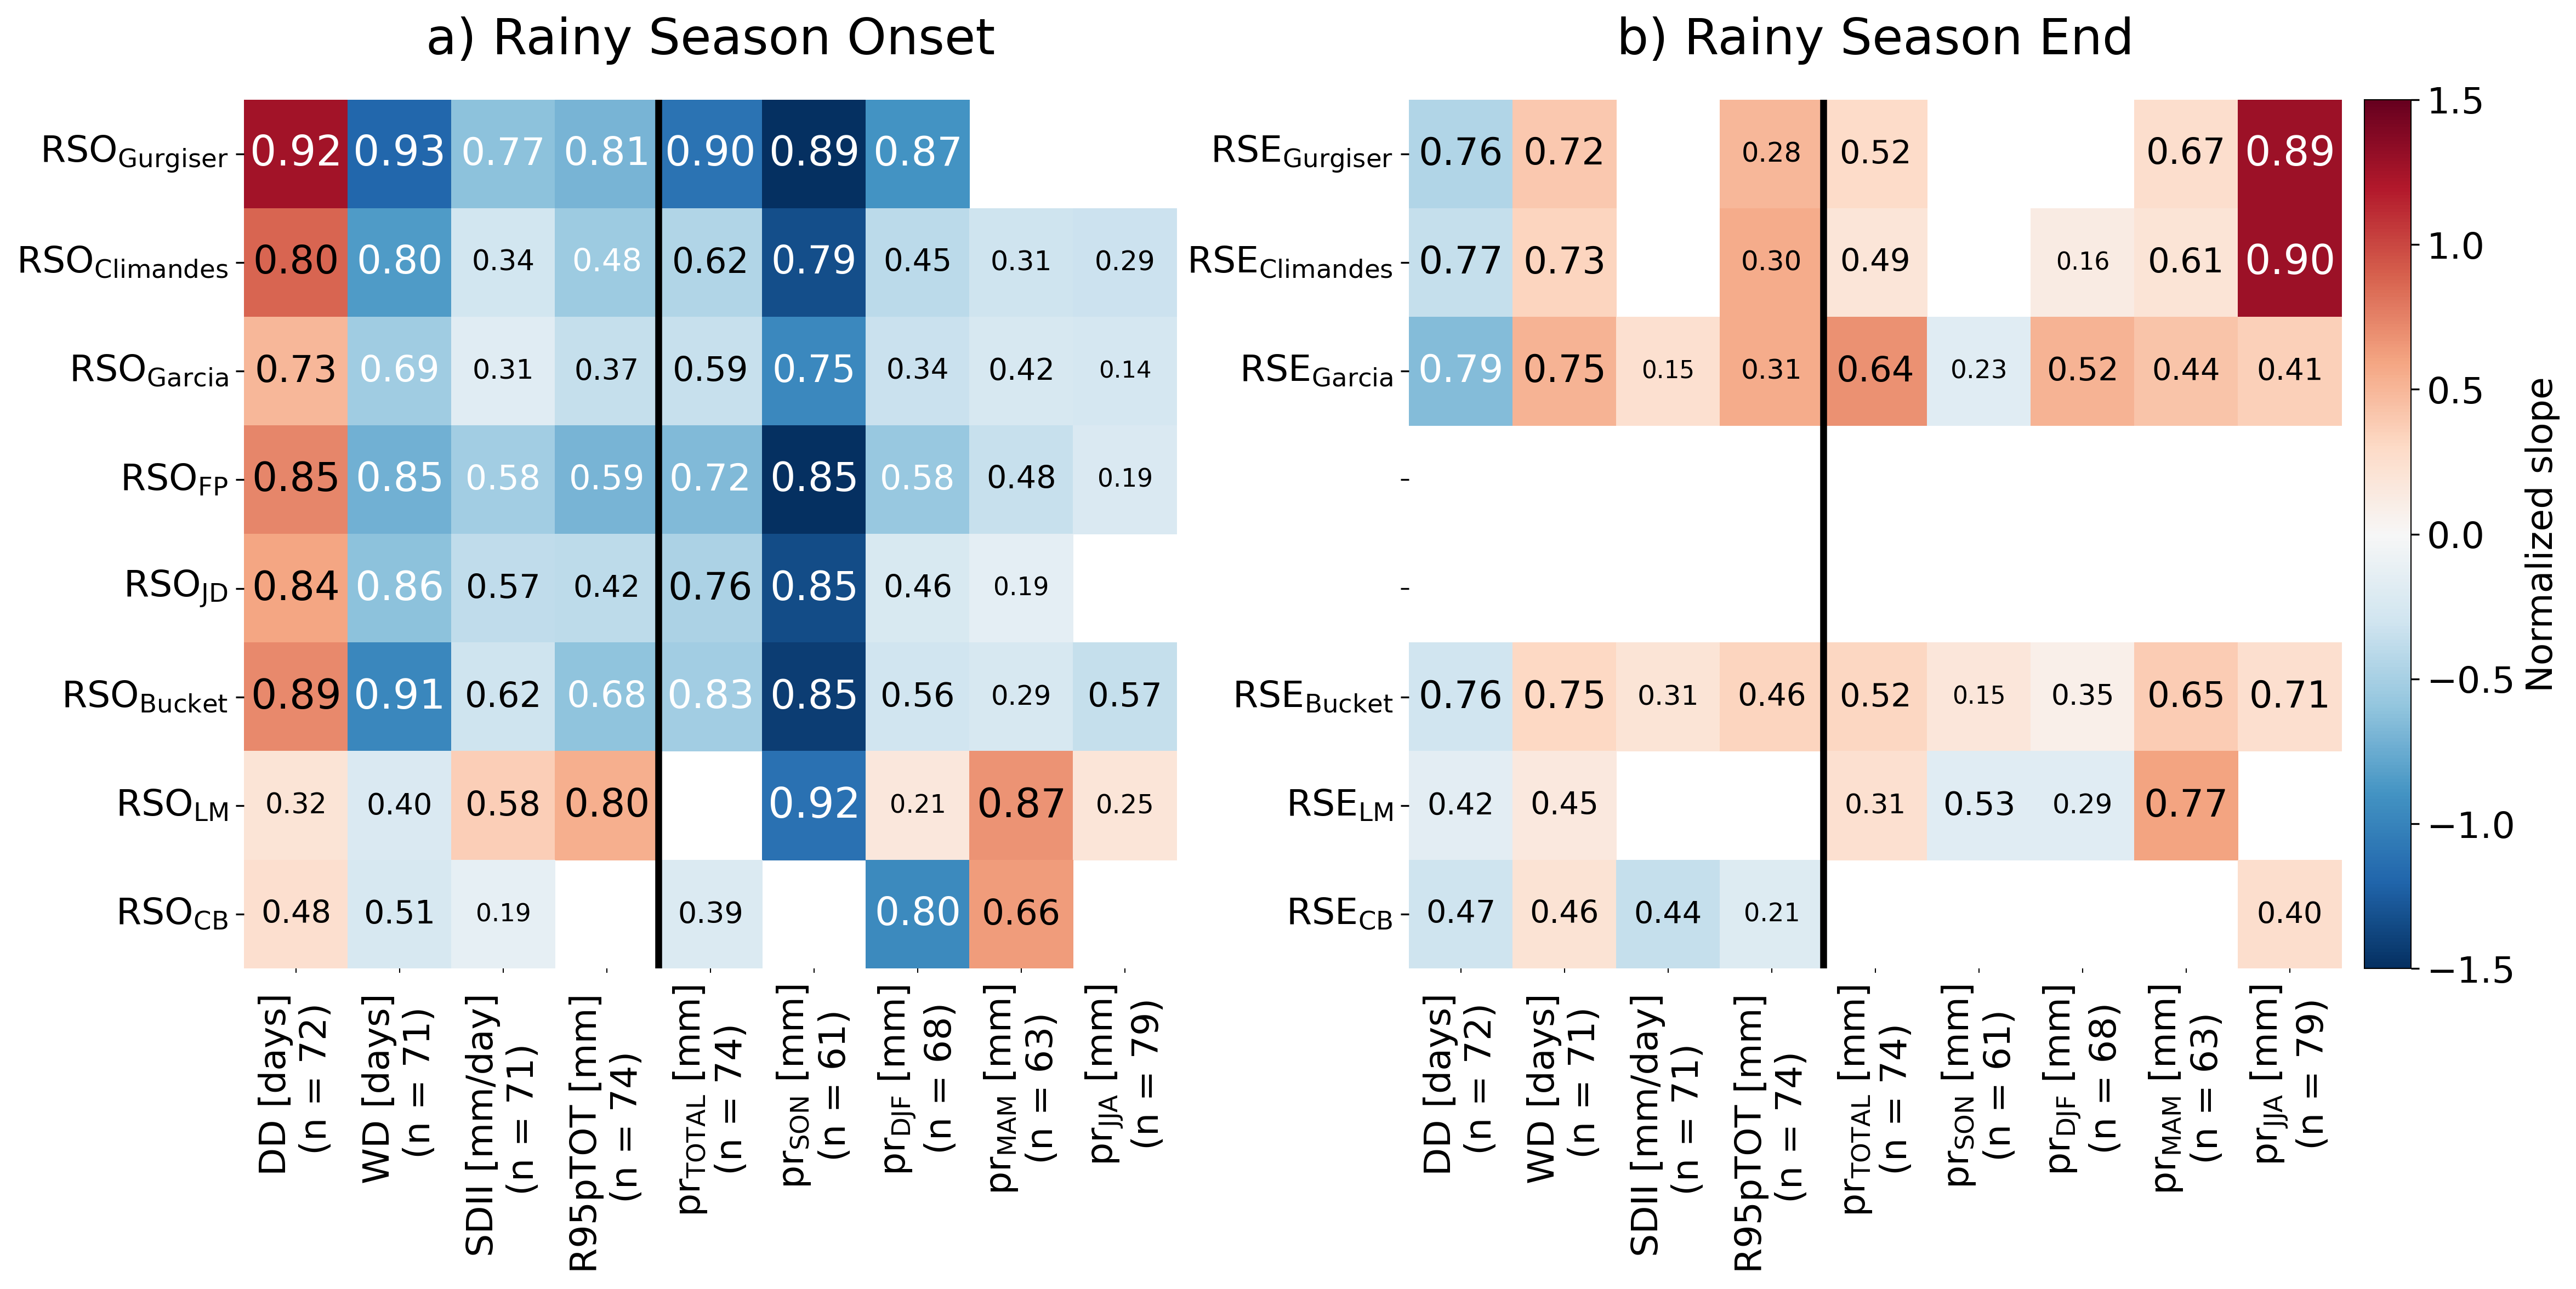

In [18]:
### Plot figure
fig, axs = plt.subplots(1,3,gridspec_kw={"width_ratios": [1, 1, 0.05]},figsize=(17,7),dpi=300)

# RSO
sheat = sns.heatmap(S_slope_array, annot=False, cmap='RdBu_r', center=0, cbar_kws={'label': 'normalized slope'}
            ,vmin=-1.5,vmax=1.5,ax=axs[0],cbar=False)
# RSE
eheat = sns.heatmap(add_nan_rows(E_slope_array), annot=False, cmap='RdBu_r', center=0, cbar_kws={'label': 'normalized slope'}
            ,vmin=-1.5,vmax=1.5,ax=axs[1],cbar=False)

# Annotate r2 values
sized_annot(S_slope_array,S_r2_array,ax=axs[0])
sized_annot(add_nan_rows(E_slope_array),add_nan_rows(E_r2_array),ax=axs[1])


# style things
axs[0].set_yticklabels(plot_Smetrics,rotation=0)
axs[0].set_xticklabels(list((s + f' \n(n = {n_bins[i]})' for i,s in enumerate(plot_Sindices))),rotation=90);
axs[1].set_yticklabels(plot_Emetrics,rotation=0)
axs[1].set_xticklabels(list((s + f' \n(n = {n_bins[i]})' for i,s in enumerate(plot_Sindices))),rotation=90);

# remove ticks for empty lines
#y_ticks = axs[1].get_yticklines()
#for i in range(5,10):
#    y_ticks[i].set_color('white')

axs[0].axvline(x=4, linewidth=3, color="k")
axs[1].axvline(x=4, linewidth=3, color="k")

plt.colorbar(axs[0].collections[0],label='Normalized slope', cax=axs[2])

for i,title in enumerate(['a) Rainy Season Onset','b) Rainy Season End']):
    axs[i].set_title(title)

pos = axs[1].get_position()
new_left = pos.x0 + .0375
axs[1].set_position([new_left,pos.y0,pos.width,pos.height])


# Some error here when saving as pdf, so just converting it
#plt.savefig('./figures/Fig05.pdf',bbox_inches='tight')
plt.savefig('./figures/Fig05.svg',bbox_inches='tight')

# Figs S4 & S5

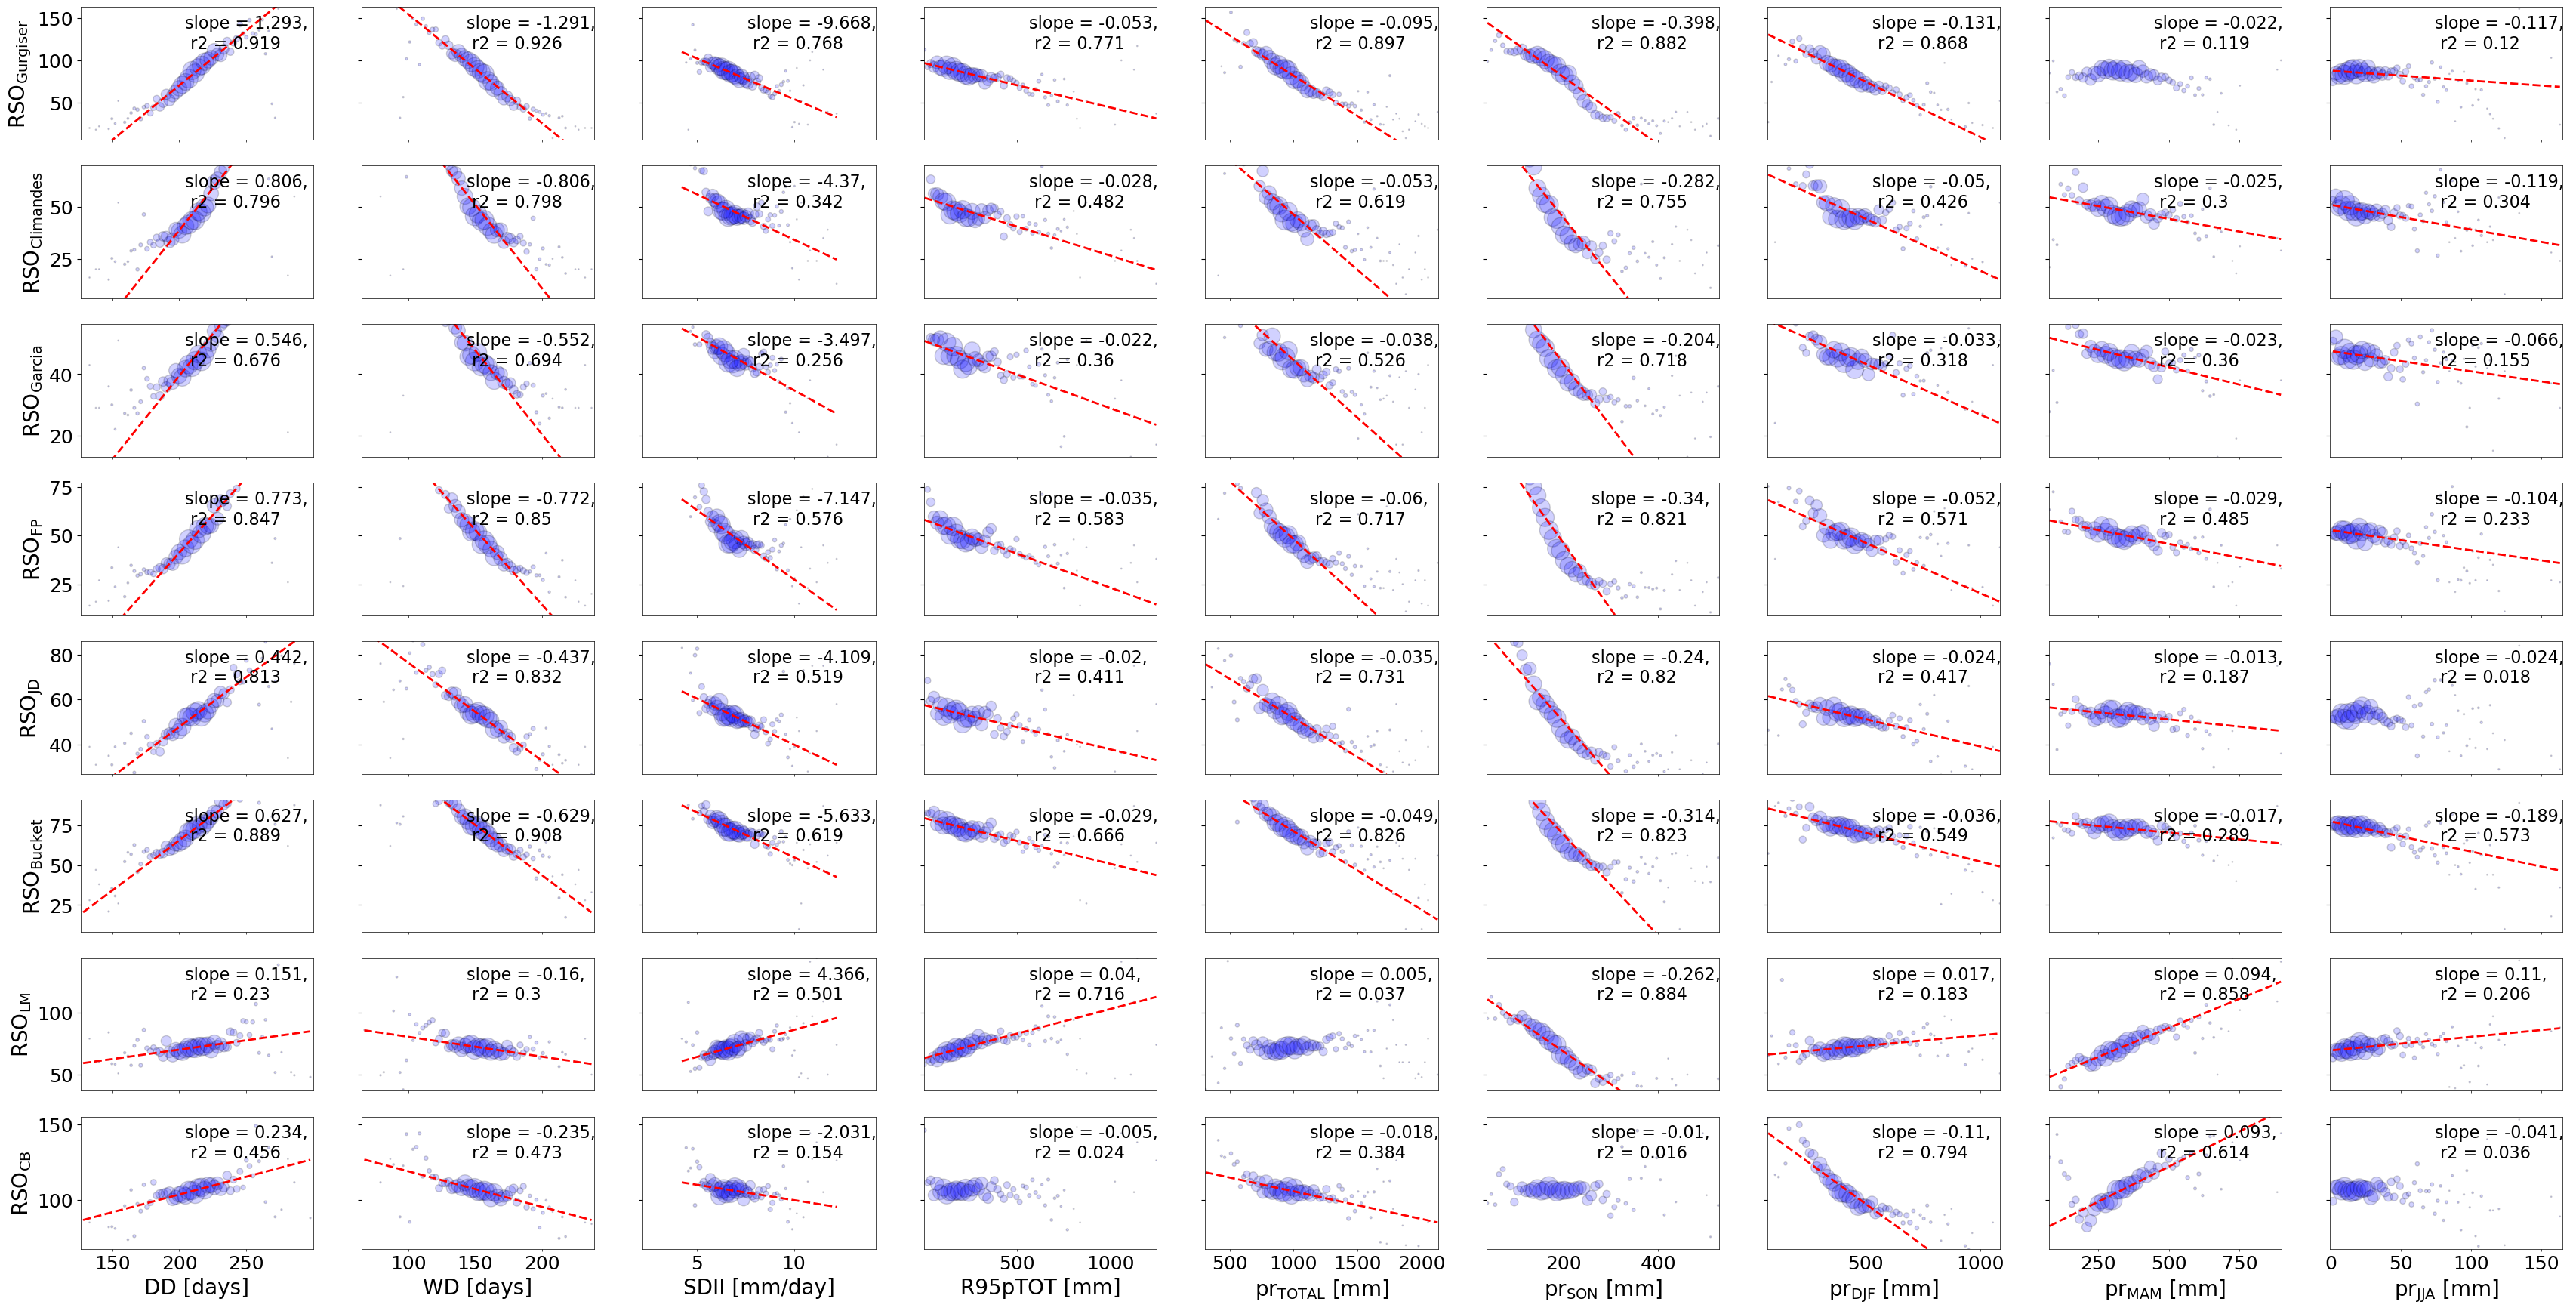

In [11]:
### Fig S4
mplier = 2.2
width = 1.75 * mplier
height = 1 * mplier
figsize = (len(Sindices)*width,len(Smetrics)*height)
    
fig, axs = plt.subplots(len(Smetrics),len(Sindices),figsize=figsize, sharex='col', sharey='row',dpi=100)

for j,climidx in enumerate(Sindices):
    bin_edges, bin_centers = get_bin_widths(ds[climidx]) # get bin sizes
    x = ds.groupby_bins(group=climidx,bins=bin_edges).mean() # average by bins
    s = ds.groupby_bins(group=climidx,bins=bin_edges).count() # count per bin
    
    
    for i,metric in enumerate(Smetrics):
        # scatterplot
        y = x[metric]
        weights=s[metric]
        axs[i,j].scatter(bin_centers,y,s=weights,alpha=.18,ec='k',fc='blue')
        
        # bin weighted linreg
        slope, r2, pvalue, y_hat = weighted_linregress(bin_centers,y,weights,scale_data=False)
        if pvalue < 0.01:
            axs[i,j].plot(bin_centers,y_hat,c='red',linestyle='--')  

        if j == 0:
            axs[i,j].set_ylabel(plot_Smetrics[i],fontsize=20)
        else:
            axs[i,j].set_ylabel('')
        if i == len(Smetrics)-1:
            axs[i,j].set_xlabel(plot_Sindices[j],fontsize=20)
        else:
            axs[i,j].set_xlabel('')
            
        axs[i,j].text(0.45, 0.8,f'slope = {np.round(slope,3)}, \n r2 = {np.round(r2,3)}',
              ha='left',va='center',transform = axs[i,j].transAxes,fontsize=16)

        axs[i,j].set_xlim(bin_centers.min()-2,bin_centers.max()+2)
        axs[i,j].set_ylim(y.min()-2,y.max()+2)
        axs[i,j].tick_params(axis='both', labelsize=18)  
    
fig.tight_layout()

# Due to the many panels, I change the position of the slope/r2 labels outside of python
plt.savefig('./figures/FigS4.svg',bbox_inches='tight')
#plt.savefig('./figures/FigS4.pdf',bbox_inches='tight')

In [12]:
# prepare y-labels
plot_Emetrics = Emetrics.copy()
plot_Emetrics = ['$RSE_{' + s.split('_')[1] + '}$' for s in plot_Emetrics]
plot_Emetrics[-2] = '$RSE_{LM}$'
plot_Emetrics[-1] = '$RSE_{CB}$'

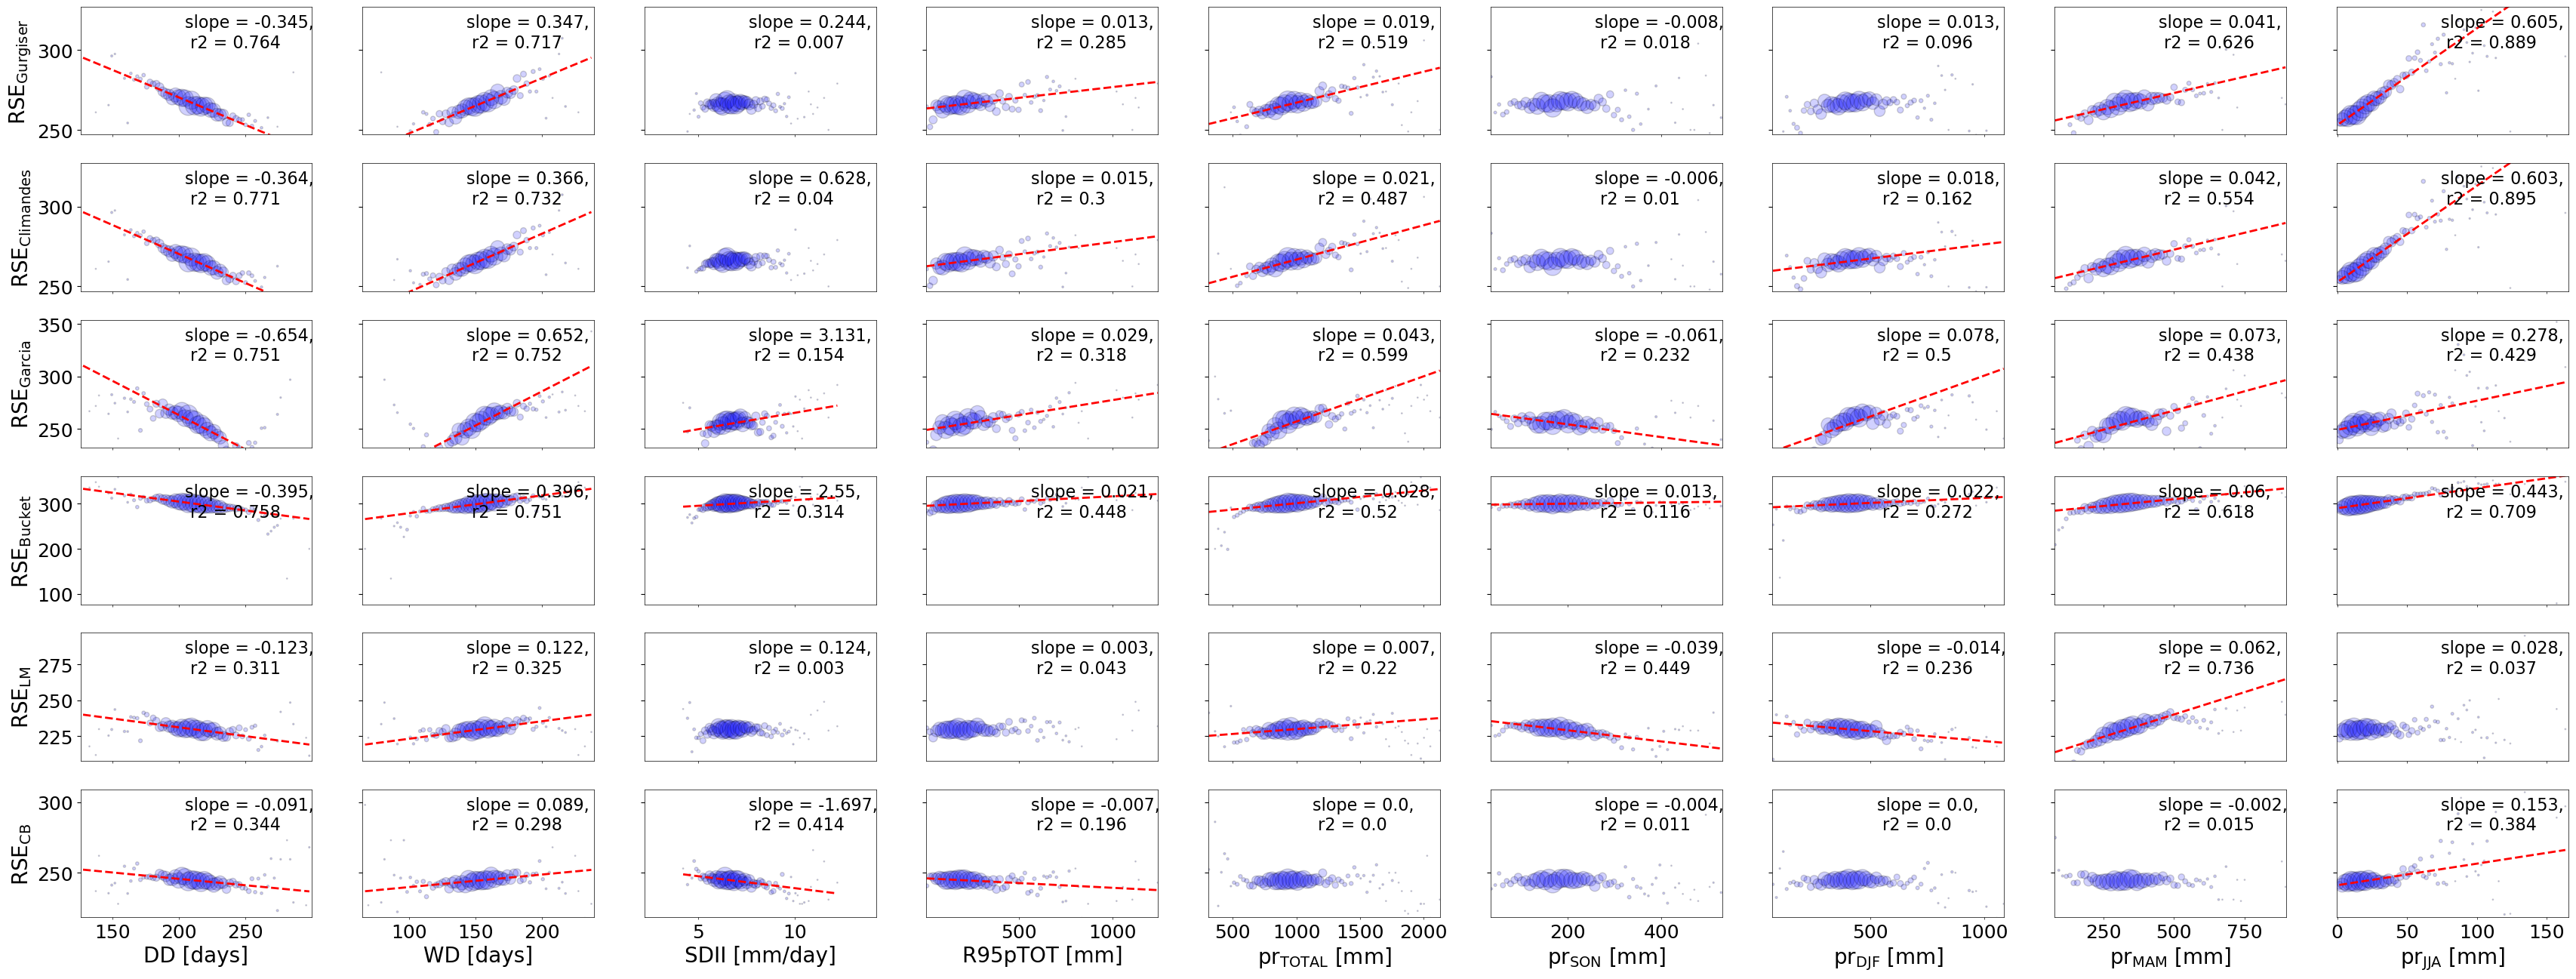

In [13]:
### Fig S5
mplier = 2.2
width = 1.75 * mplier
height = 1 * mplier
figsize = (len(Sindices)*width,len(Emetrics)*height)

fig, axs = plt.subplots(len(Emetrics),len(Sindices),figsize=figsize,sharex='col',sharey='row',dpi=100)

for j,climidx in enumerate(Sindices):
    bin_edges, bin_centers = get_bin_widths(ds[climidx]) # get bin sizes
    x = ds.groupby_bins(group=climidx,bins=bin_edges).mean() # average by bins
    s = ds.groupby_bins(group=climidx,bins=bin_edges).count() # count per bin
    
    for i,metric in enumerate(Emetrics):
        # scatterplot
        y = x[metric]
        weights=s[metric]
        axs[i,j].scatter(bin_centers,y,s=weights,alpha=.18,ec='k',fc='blue')
        
        # bin weighted linreg
        slope, r2, pvalue, y_hat = weighted_linregress(bin_centers,y,weights,scale_data=False)
        if pvalue < 0.01:
            axs[i,j].plot(bin_centers,y_hat,c='red',linestyle='--') 
            
        if j == 0:
            axs[i,j].set_ylabel(plot_Emetrics[i],fontsize=20)
        else:
            axs[i,j].set_ylabel('')
        if i == len(Emetrics)-1:
            axs[i,j].set_xlabel(plot_Sindices[j],fontsize=20)
        else:
            axs[i,j].set_xlabel('')

        axs[i,j].text(0.45, 0.8,f'slope = {np.round(slope,3)}, \n r2 = {np.round(r2,3)}',
              ha='left',va='center',transform = axs[i,j].transAxes,fontsize=16)

        axs[i,j].set_xlim(bin_centers.min()-2,bin_centers.max()+2)
        axs[i,j].set_ylim(y.min()-2,y.max()+2)
        axs[i,j].tick_params(axis='both', labelsize=18)  
       
    
fig.tight_layout()
# Due to the many panels, I change the position of the slope/r2 labels outside of python
plt.savefig('./figures/FigS5.svg',bbox_inches='tight')
#plt.savefig('./figures/FigS5.pdf',bbox_inches='tight')